In [45]:
import warnings
warnings.filterwarnings("ignore")
import os
import glob
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import mpl_toolkits.basemap as bm
# from mpi4py import MPI
# from multiprocessing import Pool

## TC probability distribution

Western Pacific (WP) locations: 5–60°N 100°–180°E

In [46]:
def load_and_process_file(file_path,time,lat,lon):

    with Dataset(file_path, 'r') as ds:
        time_var = ds.variables[time]
        time_data = num2date(np.ma.masked_invalid(time_var[:]), 
                             time_var.units,
                             only_use_cftime_datetimes=False, 
                             only_use_python_datetimes=True)
        
        lat_data = ds.variables[lat][:]
        lon_data = ds.variables[lon][:]
    
    roi_years = []
    for t, y, x in zip(time_data, lat_data, lon_data):
        for i in range(len(y)): # loop over all points in the length of the lat/lon arrays
            if 5 <= y[i] <= 60 and 100 <= x[i] <= 180:
                roi_years.append(t[0].year)
                break # break the loop after the first valid point is found
    
    return roi_years


def process_files(file_pattern, time, lat, lon):
    all_counts = {}
    
    for file in glob.glob(file_pattern):
        years = load_and_process_file(file, time, lat, lon)
        unique_years, counts = np.unique(years, return_counts=True)
        all_counts[file] = dict(zip(unique_years, counts))
    
    return pd.DataFrame(all_counts).fillna(0)

In [47]:
# When calculating probability distribution:
def calculate_probability_distribution(counts, bins):

    all_counts = np.concatenate([counts[col].dropna().values for col in counts.columns])  
    hist, bin_edges = np.histogram(all_counts, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return bin_centers, hist

In [48]:
file= Dataset('./Dataset/IBTrACS.WP.v04r01.nc', 'r')
print(file.variables.keys())

dict_keys(['numobs', 'sid', 'season', 'number', 'basin', 'subbasin', 'name', 'source_usa', 'source_jma', 'source_cma', 'source_hko', 'source_kma', 'source_new', 'source_reu', 'source_bom', 'source_nad', 'source_wel', 'source_td5', 'source_td6', 'source_ds8', 'source_neu', 'source_mlc', 'time', 'iso_time', 'nature', 'lat', 'lon', 'wmo_wind', 'wmo_pres', 'wmo_agency', 'track_type', 'main_track_sid', 'dist2land', 'landfall', 'iflag', 'usa_agency', 'usa_atcf_id', 'usa_lat', 'usa_lon', 'usa_record', 'usa_status', 'usa_wind', 'usa_pres', 'usa_sshs', 'usa_r34', 'usa_r50', 'usa_r64', 'usa_poci', 'usa_roci', 'usa_rmw', 'usa_eye', 'tokyo_lat', 'tokyo_lon', 'tokyo_grade', 'tokyo_wind', 'tokyo_pres', 'tokyo_r50_dir', 'tokyo_r50_long', 'tokyo_r50_short', 'tokyo_r30_dir', 'tokyo_r30_long', 'tokyo_r30_short', 'tokyo_land', 'cma_lat', 'cma_lon', 'cma_cat', 'cma_wind', 'cma_pres', 'hko_lat', 'hko_lon', 'hko_cat', 'hko_wind', 'hko_pres', 'kma_lat', 'kma_lon', 'kma_cat', 'kma_wind', 'kma_pres', 'kma_r50_

In [49]:
file_current = Dataset('./Dataset/d4PDF_tropical_cyclone/MRI_HPB_m001.nc', 'r')
print(file_current.variables.keys())# show all variables of the model data

dict_keys(['track_time', 'track_lat', 'track_lon', 'track_pres', 'track_wind'])


In [50]:
count_obs= process_files('./Dataset/IBTrACS.WP.v04r01.nc', 'time', 'lat', 'lon')

In [51]:
count_current1 = process_files('./Dataset/d4PDF_tropical_cyclone/MRI_HPB_m001.nc','track_time','track_lat','track_lon') #process single current file

In [52]:
count_4K1 = process_files('./Dataset/d4PDF_tropical_cyclone/MRI_HFB_4K_CC_m110.nc','track_time','track_lat','track_lon') #process single 4K file

In [53]:
all_data_current = process_files('./Dataset/d4PDF_tropical_cyclone/MRI_HPB_m*.nc','track_time','track_lat','track_lon') #process all current files

In [54]:
all_data_4k = process_files('./Dataset/d4PDF_tropical_cyclone/MRI_HFB_4K*.nc','track_time','track_lat','track_lon') #process all 4K files

In [78]:
bins_obs, prob_obs = calculate_probability_distribution(count_obs,10)
bins_current1, prob_current1 = calculate_probability_distribution(count_current1,10)
bins_current_all, prob_current_all = calculate_probability_distribution(all_data_current,18)

In [79]:
bins_4K1, prob_4K1 = calculate_probability_distribution(count_4K1,10)

In [80]:
bins_4K_all, prob_4K_all = calculate_probability_distribution(all_data_4k,18)

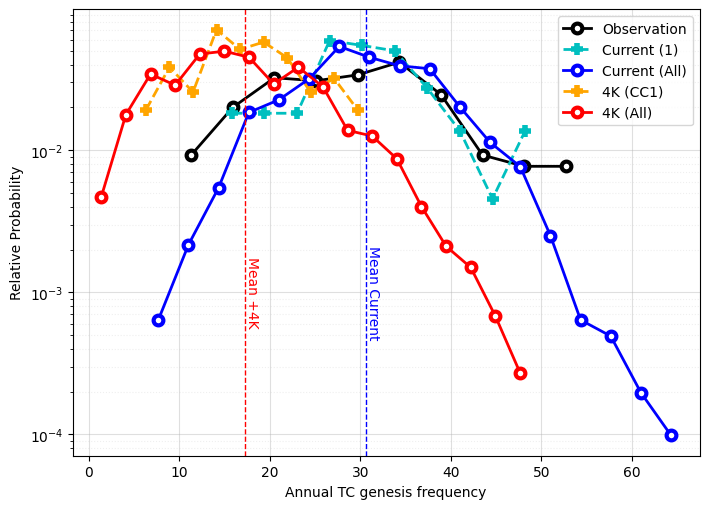

In [81]:
plt.figure(figsize=(7,5))
plt.semilogy(bins_obs, prob_obs, color='black', 
        linewidth=2, marker='o', markersize=7, 
        markerfacecolor='white',
        markeredgecolor='black',
        markeredgewidth=3,
        label='Observation')

plt.semilogy(bins_current1, prob_current1, 
            'c--',linewidth=2, marker='+', markeredgewidth=4,
            markersize=8, label='Current (1)')
plt.semilogy(bins_current_all, prob_current_all,color='blue', 
        linewidth=2, marker='o', markersize=7, 
        markerfacecolor='white',
        markeredgecolor='blue',
        markeredgewidth=3,
        label='Current (All)')
plt.semilogy(bins_4K1, prob_4K1, 
            '--',color='orange',linewidth=2, marker='+', markeredgewidth=4,
            markersize=8, label='4K (CC1)')
plt.semilogy(bins_4K_all, prob_4K_all,color='red',
        linewidth=2, marker='o', markersize=7, 
        markerfacecolor='white',
        markeredgecolor='red',
        markeredgewidth=3,
        label='4K (All)')

# plot mean vertical line
plt.axvline(all_data_current.mean().mean(), color='blue', linestyle='--', linewidth=1)
plt.text(all_data_current.mean().mean(), 0.001, 'Mean Current', 
         rotation=-90,
         color='blue',
         verticalalignment='center')
plt.axvline(all_data_4k.mean().mean(), color='red', linestyle='--', linewidth=1)
plt.text(all_data_4k.mean().mean(), 0.001, 'Mean +4K', 
         rotation=-90,
         color='red',
         verticalalignment='center')
# Configure grid
plt.grid(True, which='major', linestyle='-', alpha=0.4)
plt.grid(True, which='minor', linestyle=':', alpha=0.2)
plt.tight_layout()
plt.xlabel('Annual TC genesis frequency')
plt.ylabel('Relative Probability')
plt.legend()

In [76]:
def plot_tc_genesis(data_current, obs_data, region_name, ylim=(0,60)):
    # Calculate correlations
    r_all = np.corrcoef(obs_data.values, data_current.mean(axis=1).values)[0,1]
    r_each = np.mean([np.corrcoef(obs_data.values, data_current[col].values)[0,1] 
                      for col in data_current.columns])
    
    # Calculate percentiles for shading bands
    percentiles = [5, 10, 20, 35, 65, 80, 90, 95]
    perc_curves = np.percentile(data_current, percentiles, axis=1)
    
    fig, ax = plt.subplots(figsize=(15, 4))
    
    # Plot gray shaded percentile bands
    for i in range(len(percentiles)//2):
        ax.fill_between(data_current.index, 
                        perc_curves[i], 
                        perc_curves[-i-1],
                        color='gray',
                        alpha=0.1 + i*0.1)
    
    # Plot ensemble mean and observations
    mean_line = ax.plot(data_current.index, data_current.mean(axis=1), 
                        'g-', linewidth=2)
    obs_line = ax.plot(obs_data.index, obs_data.values, 
                       'r-', linewidth=2)
    
    ax.legend([mean_line[0], obs_line[0]],
              ['Ensemble mean', 'Observations'],
              loc='upper left')
    
    
    # Styling
    ax.set_ylim(ylim)
    ax.set_xlim(data_current.index[0], data_current.index[-1])
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.set_title(f"{region_name} [R_ALL={r_all:.2f}, R_EACH={r_each:.2f}]",
                 fontsize=14)
    ax.set_xlabel('[YEAR]', fontsize=12)
    ax.set_ylabel('[TC number]', fontsize=12)
    
    return fig, ax

(<Figure size 1500x400 with 1 Axes>,
 <Axes: title={'center': 'WP [R_ALL=0.49, R_EACH=0.36]'}, xlabel='[YEAR]', ylabel='[TC number]'>)

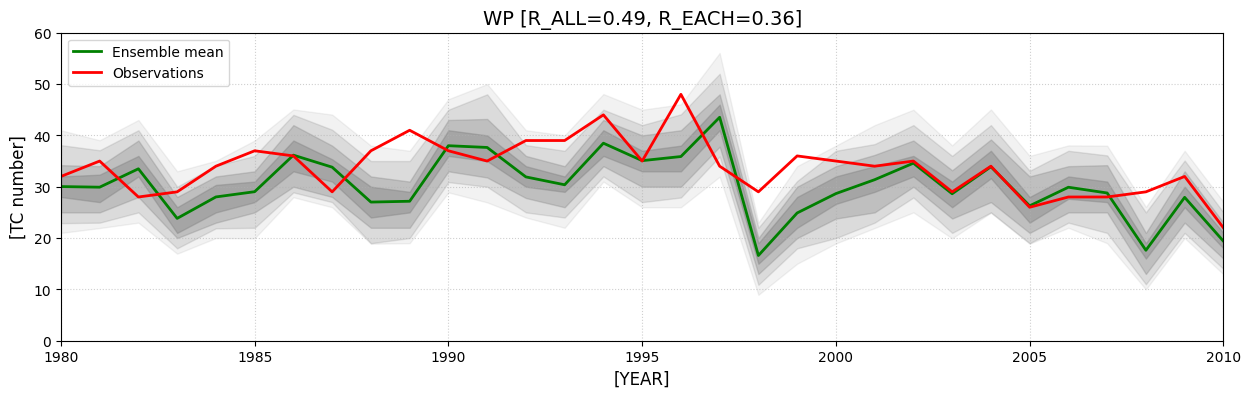

In [77]:
plot_tc_genesis(all_data_current.loc[1980:2010], count_obs.loc[1980:2010].mean(axis=1),'WP')

## TC occurrence frequency

In [62]:
# define the WP bounding box and grid resolution
WP_bounds = [5, 100, 60, 180] # [lat_min, lon_min, lat_max, lon_max]
grid_resolution = 2.5 # degrees
